In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pybaseball as pb
import math
import plotly.express as px
import datetime as dt

sns.set_style("darkgrid")
pd.set_option("display.max_columns", None)

In [2]:
def get_season_data():
    """
    queries 2022 statcast data week-by-week from opening day up to current date to handle api limits.
    """
    weeks = []
    start = dt.date(2022, 4, 7)
    today = dt.date.today()
    days = (today-start).days
    num_weeks = (days // 7) + 1
    counter = 0
    for d in range(days):
        if d%7 == 0:
            end = start + dt.timedelta(days=7)
            week = pb.statcast(start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))
            weeks.append(week)
            counter+=1
            print("week {}/{} complete".format(counter, num_weeks))
            
            
        elif d == days:
            end = start + dt.timedelta(days=(d%7))
            week = pb.statcast(start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))
            counter+=1
            print("week {}/{} complete".format(counter, num_weeks))
            
        start = end
    return pd.concat(weeks)

In [3]:
df = get_season_data()

This is a large query, it may take a moment to complete


  0%|          | 0/8 [00:00<?, ?it/s]

Creating a batter name column from mlbam ids

In [ ]:
names = pb.playerid_reverse_lookup(df['batter'])
names['batter_name'] = names['name_first'] + " " + names['name_last']
names = names[['key_mlbam', 'batter_name']]

Gathering player lookup table. This may take a moment.


In [ ]:
df = pd.merge(df, names, how='left', left_on='batter', right_on='key_mlbam')

In [ ]:
df['batter_name']

0           brendan rodgers
1           brendan rodgers
2           brendan rodgers
3           brendan rodgers
4           brendan rodgers
                ...        
354774    willson contreras
354775    willson contreras
354776    christopher morel
354777    christopher morel
354778    christopher morel
Name: batter_name, Length: 354779, dtype: object

In [ ]:
len(df)

354779

In [ ]:
df['woba_denom'].describe()

count    90727.000000
mean         0.996484
std          0.059192
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: woba_denom, dtype: float64

Subsetting for batted ball events with non-null variables of interest

In [ ]:
bbe = df.loc[df['description'] == 'hit_into_play',]
bbe = bbe.dropna(subset=['launch_speed', 'launch_angle', 'hc_x', 'hc_y'])

In [ ]:
len(bbe)

62063

<AxesSubplot:>

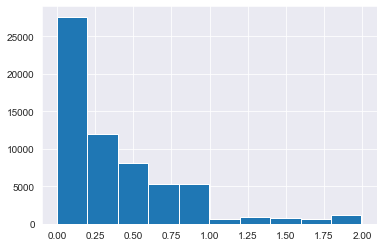

In [ ]:
bbe['estimated_woba_using_speedangle'].hist()

training a random forest regression model based on exit velocity and launch angle and using cross-validation to measure performance

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
X = bbe[['launch_speed', 'launch_angle']]
y = bbe['woba_value'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
model = RandomForestRegressor(
    n_estimators=100,
    min_samples_leaf = 100
)

In [ ]:
model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=100)

In [ ]:
cross_val_score(model, X, y, cv=5)

/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is depre

array([0.40156316, 0.40197043, 0.43370065, 0.43410518, 0.43617862])

In [ ]:
y_pred = model.predict(X)
bbe['rf_xwoba'] = y_pred

grouping events by batter to get mean xwobacon for each player

In [ ]:
xwobacon_leaders = bbe.groupby('batter_name')['rf_xwoba'].agg(['mean', 'count'])

In [ ]:
xwobacon_leaders.sort_values(by='count', ascending=False)

,mean,count
batter_name,,
whit merrifield,0.317879,287
cesar hernandez,0.333425,275
adam frazier,0.307492,269
nolan arenado,0.345226,269
cedric mullins,0.342714,268
...,...,...
dj stewart,0.055470,1
mickey mcdonald,0.448849,1
jeter downs,0.171314,1


In [ ]:
df.events.unique()

array(['strikeout', None, 'field_out', 'single', 'force_out',
       'grounded_into_double_play', 'walk', 'double', 'home_run',
       'double_play', 'field_error', 'fielders_choice', 'hit_by_pitch',
       'triple', 'sac_fly', 'fielders_choice_out', 'catcher_interf',
       'sac_bunt', 'pickoff_2b', 'caught_stealing_2b', 'other_out',
       'strikeout_double_play', 'triple_play', 'caught_stealing_3b',
       'pickoff_1b', 'wild_pitch', 'sac_fly_double_play',
       'caught_stealing_home', 'game_advisory', 'pickoff_3b'],
      dtype=object)

In [ ]:
df.loc[df['launch_speed'].isna() & df['woba_denom']!=0].events.unique()

array(['strikeout', 'walk', 'hit_by_pitch', 'catcher_interf',
       'strikeout_double_play'], dtype=object)

Counting all woba events (bbe, strikeouts, hbp, and BB) to count up total plate appearances

In [ ]:
num_pa = df.groupby('batter_name')['woba_value'].agg(['mean', 'count'])

In [ ]:
num_pa.nlargest(10, 'count')

,mean,count
batter_name,,
cesar hernandez,0.296486,370
tommy edman,0.337027,370
aaron judge,0.42279,362
juan soto,0.364088,362
cedric mullins,0.330748,361
paul goldschmidt,0.456806,360
whit merrifield,0.254888,358
jurickson profar,0.327949,356
bo bichette,0.329096,354


In [ ]:
df['woba_value'].count()

91044

In [ ]:
xwobacon_leaders[xwobacon_leaders.index == 'pete alonso']

,mean,count
batter_name,,
pete alonso,0.445175,231


In [ ]:
xwobacon_leaders[xwobacon_leaders.index == 'rafael devers']

,mean,count
batter_name,,
rafael devers,0.450724,252


In [ ]:
xwobacon_leaders[xwobacon_leaders.index == 'mike trout']

,mean,count
batter_name,,
mike trout,0.528639,174


calculating xwoba from bbe xwobacon and non-bbe woba

In [ ]:
xwobacon_leaders['non_bbe'] = num_pa['mean']
xwobacon_leaders['non_bbe_count'] = num_pa['count'].sub(xwobacon_leaders['count'])
xwobacon_leaders['total'] = num_pa['count']

xwobacon_leaders['xwoba'] = ((xwobacon_leaders['mean']*xwobacon_leaders['count']) + \
                            (xwobacon_leaders['non_bbe']*xwobacon_leaders['non_bbe_count'])) / \
                            xwobacon_leaders['total']

In [ ]:
xwobacon_leaders.nlargest(25, "total")

,mean,count,non_bbe,non_bbe_count,total,xwoba
batter_name,,,,,,
cesar hernandez,0.333425,275,0.296486,95.0,370,0.323941
tommy edman,0.363114,265,0.337027,105.0,370,0.355711
aaron judge,0.552177,233,0.42279,129.0,362,0.50607
juan soto,0.398919,239,0.364088,123.0,362,0.387084
cedric mullins,0.342714,268,0.330748,93.0,361,0.339631
paul goldschmidt,0.430190,244,0.456806,116.0,360,0.438766
whit merrifield,0.317879,287,0.254888,71.0,358,0.305386
jurickson profar,0.332169,249,0.327949,107.0,356,0.3309
bo bichette,0.428562,246,0.329096,108.0,354,0.398216


transforming hit coordinates over 1st quadrant of xy-plane for ease in calculating spray angle

In [ ]:
bbe['hc_x_adj'] = bbe['hc_x'].sub(126)
bbe['hc_y_adj'] = 204.5 - bbe['hc_y']
rad = -math.pi/4
rotation_mat = np.array([[math.cos(rad), math.sin(rad)],
                         [-math.sin(rad), math.cos(rad)]])
bbe[['field_x', 'field_y']] = bbe[['hc_x_adj', 'hc_y_adj']].dot(rotation_mat).astype(np.float64)

In [ ]:
bbe_plot = bbe.dropna(subset=['field_x', 'field_y', 'woba_value'])

In [ ]:
bbe_plot['woba_value'].value_counts()

0.00    41505
0.90    13690
1.25     3974
2.00     2553
1.60      341
Name: woba_value, dtype: Int64

Text(0.5, 1.0, 'Random forest xwOBA estimates (no spray angle)')

/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


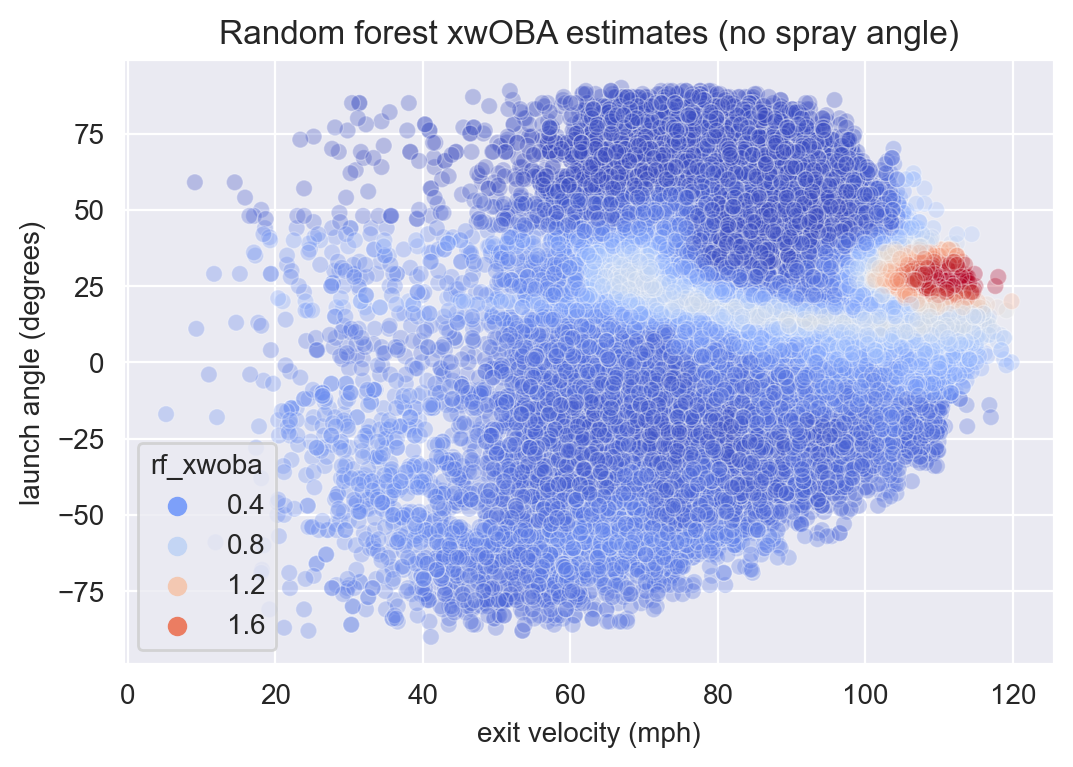

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax = sns.scatterplot(x='launch_speed', 
           y='launch_angle',
           hue='rf_xwoba',
           palette='coolwarm',
           alpha=0.3,
           data=bbe)
ax.set_xlabel("exit velocity (mph)")
ax.set_ylabel("launch angle (degrees)")
ax.set_title("Random forest xwOBA estimates (no spray angle)")


calculating spray angle (theta_deg) from inverse tangent function of transformed hit coordinates

In [ ]:
bbe['field_x'] = bbe['field_x'].astype(float)
bbe['field_y'] = bbe['field_y'].astype(float)
bbe['theta'] = np.arctan(bbe['field_y'].div(bbe['field_x']))
bbe['theta_deg'] = bbe['theta'].mul(180/math.pi)

<AxesSubplot:>

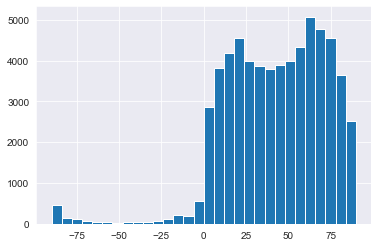

In [ ]:
bbe['theta_deg'].hist(bins=30)

visualizing distribution of home runs by spray angle

In [ ]:
homers = bbe.loc[bbe['events'] == 'home_run']

<AxesSubplot:>

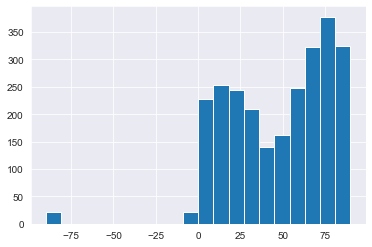

In [ ]:
homers['theta_deg'].hist(bins=20)

incorporating spray angle into random forest model

In [ ]:
bbe_spray = bbe.dropna(subset=['launch_speed', 'launch_angle', 'woba_value'])
bbe_spray = bbe_spray.fillna(0)

In [ ]:
X_spray = bbe_spray[['launch_speed', 'launch_angle', 'theta_deg']]
y_spray = bbe_spray['woba_value'].values

In [ ]:
X_spray.isna().sum()

launch_speed    0
launch_angle    0
theta_deg       0
dtype: int64

In [ ]:
cross_val_score(model, X_spray, y_spray, cv=5)

/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is depre

array([0.47660253, 0.47239426, 0.50346363, 0.49989744, 0.50531854])

In [ ]:
model.fit(X_spray, y_spray)

RandomForestRegressor(min_samples_leaf=100)

In [ ]:
y_pred_spray = model.predict(X_spray)

In [ ]:
len(y_pred_spray)

62063

In [ ]:
len(bbe)

62063

In [ ]:
bbe['rf_spray_xwoba'] = y_pred_spray

In [ ]:
len(y_pred_spray)

62063

generating spray xwoba leaderboards

In [ ]:
spray_xwobacon = bbe.groupby('batter_name')['rf_spray_xwoba'].agg(['mean', 'count'])

In [ ]:
spray_xwobacon.sort_values('count', ascending=False)

,mean,count
batter_name,,
whit merrifield,0.294438,287
cesar hernandez,0.343478,275
adam frazier,0.303554,269
nolan arenado,0.360678,269
cedric mullins,0.343430,268
...,...,...
dj stewart,0.093286,1
mickey mcdonald,0.432411,1
jeter downs,0.165615,1


In [ ]:
bbe['rf_spray_xwoba'].describe()

count    62063.000000
mean         0.369492
std          0.386023
min          0.000000
25%          0.083732
50%          0.232089
75%          0.562779
max          1.987022
Name: rf_spray_xwoba, dtype: float64

In [ ]:
xwobacon_leaders['spray_xwoba'] = spray_xwobacon['mean']
xwobacon_leaders['spray_xwoba_count'] = spray_xwobacon['count']
xwobacon_leaders['diff'] = xwobacon_leaders['spray_xwoba'].sub(xwobacon_leaders['xwoba'])

In [ ]:
xwobacon_leaders.sort_values('total', ascending=False)

,mean,count,non_bbe,non_bbe_count,total,xwoba,spray_xwoba,spray_xwoba_count,diff
batter_name,,,,,,,,,
cesar hernandez,0.333425,275,0.296486,95.0,370,0.323941,0.343478,275,0.019537
tommy edman,0.363114,265,0.337027,105.0,370,0.355711,0.354661,265,-0.00105
juan soto,0.398919,239,0.364088,123.0,362,0.387084,0.392840,239,0.005756
aaron judge,0.552177,233,0.42279,129.0,362,0.50607,0.561447,233,0.055377
cedric mullins,0.342714,268,0.330748,93.0,361,0.339631,0.343430,268,0.003799
...,...,...,...,...,...,...,...,...,...
yermin mercedes,0.014454,1,0.0,1.0,2,0.007227,0.012117,1,0.00489
reiver sanmartin,0.114291,1,0.0,1.0,2,0.057146,0.035040,1,-0.022106
khalil lee,0.826923,2,1.0,0.0,2,0.826923,0.816491,2,-0.010432


In [ ]:
len(bbe)

62063

In [ ]:
len(bbe.loc[bbe['batter_name'] == 'joc pederson'])

158

In [ ]:
non_bbe = df.loc[(df['woba_denom'] == 1) & (df['launch_speed'].isna())]


In [ ]:
non_bbe

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,key_mlbam,batter_name
0,FF,2022-04-14,92.4,-2.73,5.08,"Givens, Mychal",663898,571710,strikeout,swinging_strike,<NA>,<NA>,<NA>,<NA>,1,Brendan Rodgers strikes out swinging.,R,R,R,COL,CHC,S,2,None,2,2,2022,-0.03,0.81,-0.29,3.42,<NA>,<NA>,592178,2,9,Bot,<NA>,<NA>,<NA>,<NA>,543228,<NA>,<NA>,6.307194,-134.660579,-0.28209,-1.563605,24.815642,-22.310743,3.37,1.53,<NA>,<NA>,<NA>,93.5,2513,6.5,662950,571710,543228,643524,663611,621550,663538,664023,542364,673548,54.0,<NA>,<NA>,0.0,1,0,0,<NA>,77,7,4-Seam Fastball,2,5,2,5,5,2,2,5,Standard,Standard,214,-0.014,-0.192,663898,brendan rodgers
13,FF,2022-04-14,93.4,-2.7,4.77,"Givens, Mychal",453568,571710,strikeout,called_strike,<NA>,<NA>,<NA>,<NA>,4,Charlie Blackmon called out on strikes.,R,L,R,COL,CHC,S,2,None,1,2,2022,-0.58,0.86,-0.76,2.43,<NA>,<NA>,<NA>,0,9,Bot,<NA>,<NA>,<NA>,<NA>,543228,<NA>,<NA>,6.276758,-136.122486,-2.313903,-8.425016,22.980737,-21.001384,3.59,1.67,<NA>,<NA>,<NA>,94.4,2492,6.3,662950,571710,543228,643524,663611,621550,663538,664023,542364,673548,54.24,<NA>,<NA>,0.0,1,0,0,<NA>,74,4,4-Seam Fastball,2,5,2,5,5,2,2,5,Infield shift,Standard,231,-0.021,-0.161,453568,charlie blackmon
17,SL,2022-04-14,91.5,-1.0,6.55,"Kinley, Tyler",621550,641755,strikeout,swinging_strike,<NA>,<NA>,<NA>,<NA>,6,Patrick Wisdom strikes out swinging.,R,R,R,COL,CHC,S,2,None,1,2,2022,0.3,0.21,0.71,2.18,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,553869,<NA>,<NA>,3.62073,-133.371405,-5.665378,2.919941,24.076085,-28.739097,3.47,1.59,<NA>,<NA>,<NA>,91.0,2265,5.5,662950,641755,553869,543068,663898,641857,578428,592178,602074,453568,54.95,<NA>,<NA>,0.0,1,0,0,<NA>,73,5,Slider,2,5,5,2,5,2,5,2,Standard,Standard,183,0.001,-0.071,621550,patrick wisdom
22,SL,2022-04-14,87.9,-1.01,6.48,"Kinley, Tyler",664023,641755,strikeout,swinging_strike,<NA>,<NA>,<NA>,<NA>,7,Ian Happ strikes out swinging.,R,L,R,COL,CHC,S,2,None,1,2,2022,0.28,0.14,-0.56,2.04,<NA>,<NA>,<NA>,1,9,Top,<NA>,<NA>,<NA>,<NA>,553869,<NA>,<NA>,0.511192,-128.189901,-5.012464,3.05691,22.686577,-29.875273,3.37,1.53,<NA>,<NA>,<NA>,87.4,2489,5.5,662950,641755,553869,543068,663898,641857,578428,592178,602074,453568,54.95,<NA>,<NA>,0.0,1,0,0,<NA>,72,5,Slider,2,5,5,2,5,2,5,2,Infield shift,Standard,117,0.003,-0.115,664023,ian happ
29,CU,2022-04-14,82.2,-1.35,5.96,"Thompson, Keegan",656582,624522,strikeout,called_strike,<NA>,<NA>,<NA>,<NA>,7,Connor Joe called out on strikes.,R,R,R,COL,CHC,S,2,None,1,2,2022,0.26,-0.97,-0.53,1.7,<NA>,<NA>,602074,2,8,Bot,<NA>,<NA>,<NA>,<NA>,543228,<NA>,<NA>,1.334527,-119.755551,-1.26703,2.286168,22.999205,-41.488617,3.33,1.66,<NA>,<NA>,<NA>,82.1,2715,6.2,662950,624522,543228,643524,663611,621550,542340,664023,641684,673548,54.34,<NA>,<NA>,0.0,1,0,0,<NA>,70,5,Curveball,2,5,2,5,5,2,2,5,Standard,Standard,40,-0.021,-0.157,656582,connor joe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
non_bbe.groupby('events')['woba_value'].mean()

events
catcher_interf                0.7
hit_by_pitch                  0.7
strikeout                0.001289
strikeout_double_play         0.0
walk                          0.7
Name: woba_value, dtype: Float64

In [ ]:
non_bbe_woba = non_bbe.groupby('batter_name')['woba_value'].agg(['mean', 'count'])
non_bbe_woba.nlargest(10, 'count')

,mean,count
batter_name,,
eugenio suarez,0.186076,158
kyle schwarber,0.242667,150
patrick wisdom,0.161151,139
joey gallo,0.163504,137
trevor story,0.164394,132
rhys hoskins,0.224427,131
christian yelich,0.227907,129
ryan mcmahon,0.222481,129
julio rodriguez,0.147656,128


In [ ]:
xwobacon_leaders['non_bbe_woba'] = non_bbe_woba['mean']
xwobacon_leaders['non_bbe_count'] = non_bbe_woba['count']

In [ ]:
xwoba_sum = xwobacon_leaders['mean'].mul(xwobacon_leaders['spray_xwoba_count'])
bbe_sum = xwobacon_leaders['spray_xwoba'].mul(xwobacon_leaders['spray_xwoba_count'])
non_bbe_sum = xwobacon_leaders['non_bbe_woba'].mul(xwobacon_leaders['non_bbe_count'])
total = xwobacon_leaders['non_bbe_count'].add(xwobacon_leaders['spray_xwoba_count'])
spray_xwoba = (bbe_sum + non_bbe_sum) / total
mlb_xwoba = (xwoba_sum + non_bbe_sum) / total


In [ ]:
spray_xwoba_leaders = pd.DataFrame.from_dict({
    'xwoba' : mlb_xwoba,
    'spray xwoba': spray_xwoba,
    'pa' : total
})
spray_xwoba_leaders['diff'] = spray_xwoba_leaders['spray xwoba'].sub(spray_xwoba_leaders['xwoba'])
spray_xwoba_leaders.nlargest(20, 'pa')

,xwoba,spray xwoba,pa,diff
batter_name,,,,
cesar hernandez,0.303501,0.310993,369.0,0.007492
tommy edman,0.32996,0.323873,368.0,-0.006087
juan soto,0.397899,0.393875,361.0,-0.004025
aaron judge,0.434422,0.440438,359.0,0.006016
cedric mullins,0.30935,0.309886,358.0,0.000536
paul goldschmidt,0.381191,0.392378,358.0,0.011187
whit merrifield,0.297853,0.279061,358.0,-0.018792
jurickson profar,0.327507,0.332791,353.0,0.005284
anthony rizzo,0.36616,0.36805,352.0,0.001889


spray xwoba leaders among those with over 150 plate appearances

In [ ]:
qual = spray_xwoba_leaders.loc[spray_xwoba_leaders['pa'] > 150].round(3)
qual.nlargest(50, 'spray xwoba')

,xwoba,spray xwoba,pa,diff
batter_name,,,,
yordan álvarez,0.476,0.459,287.0,-0.017
aaron judge,0.434,0.44,359.0,0.006
bryce harper,0.427,0.436,307.0,0.009
alejandro kirk,0.422,0.425,254.0,0.002
giancarlo stanton,0.41,0.424,280.0,0.014
mike trout,0.404,0.421,299.0,0.017
freddie freeman,0.403,0.404,349.0,0.001
rafael devers,0.389,0.403,342.0,0.014
j. d. martinez,0.384,0.398,305.0,0.014


In [ ]:
qual = qual.astype(np.float)

/var/folders/mn/zccfyhzs2q1702wmw5mwrrgr0000gn/T/ipykernel_36934/389028134.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qual = qual.astype(np.float)


0.006
0.002
0.009
0.023
-0.022
0.014
-0.023
0.023
0.021
0.017
-0.028
0.024
-0.023
0.025
0.021
-0.017


([<matplotlib.axis.YTick at 0x7fcbb4657460>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

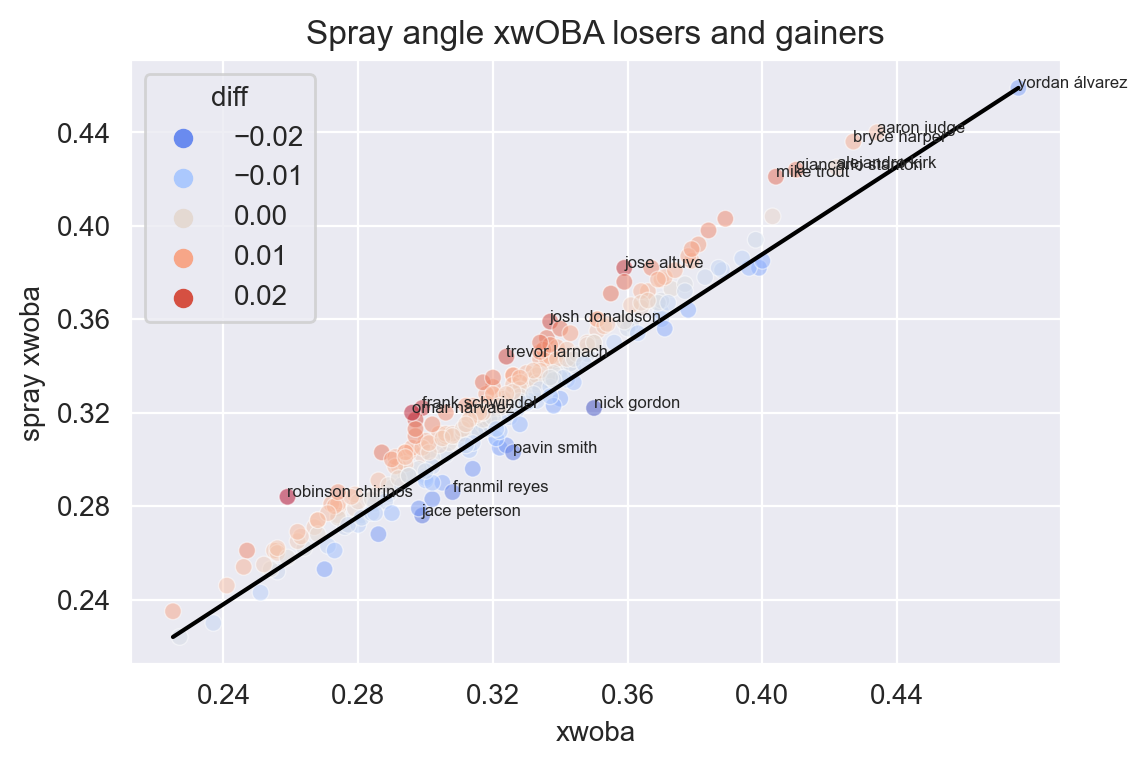

In [ ]:
fig, ax = plt.subplots(dpi=200)
sns.scatterplot(x='xwoba', y='spray xwoba', hue='diff', palette='coolwarm', alpha=0.5, ax=ax, data=qual)
for i in range(len(qual)):
  if (np.abs(qual['diff'][i]) > 0.02) | (qual['spray xwoba'][i] > 0.41):
    print(qual['diff'][i])
    s = qual.index[i]
    x = qual['xwoba'][i]
    y = qual['spray xwoba'][i]
    plt.annotate(s, (x, y), fontsize=6)
ax.set_title("Spray angle xwOBA losers and gainers")
ax.plot([qual['xwoba'].min(),qual['xwoba'].max()], [qual['spray xwoba'].min(), qual['spray xwoba'].max()], c='k')
plt.xticks(np.arange(0.24, 0.48, 0.04))
plt.yticks(np.arange(0.24, 0.48, 0.04))

In [ ]:
qual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, aaron hicks to yuli gurriel
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   xwoba        286 non-null    float64
 1   spray xwoba  286 non-null    float64
 2   pa           286 non-null    float64
 3   diff         286 non-null    float64
dtypes: float64(4)
memory usage: 11.2+ KB


In [ ]:
qual['spray xwoba'].mean(), qual['xwoba'].mean()

(0.3221818181818182, 0.32130769230769235)

|batter\_name|xwoba|spray xwoba|pa|diff|
|---|---|---|---|---|
|yordan álvarez|0\.465|0\.447|249\.0|-0\.018|
|aaron judge|0\.44|0\.443|282\.0|0\.002|
|bryce harper|0\.428|0\.432|256\.0|0\.004|
|mike trout|0\.409|0\.421|260\.0|0\.012|
|rafael devers|0\.397|0\.41|293\.0|0\.013|
|alejandro kirk|0\.394|0\.404|213\.0|0\.01|
|giancarlo stanton|0\.397|0\.404|223\.0|0\.007|
|j\. d. martinez|0\.384|0\.398|257\.0|0\.014|
|ronald acuna|0\.384|0\.398|183\.0|0\.014|
|juan soto|0\.399|0\.395|302\.0|-0\.005|
|pete alonso|0\.383|0\.393|292\.0|0\.01|
|joc pederson|0\.407|0\.391|191\.0|-0\.015|
|willson contreras|0\.39|0\.391|251\.0|0\.001|
|freddie freeman|0\.388|0\.389|292\.0|0\.0|
|trey mancini|0\.376|0\.384|260\.0|0\.007|
|kyle tucker|0\.393|0\.383|249\.0|-0\.009|
|austin riley|0\.377|0\.382|297\.0|0\.005|
|josé abreu|0\.397|0\.381|282\.0|-0\.016|
|byron buxton|0\.367|0\.379|218\.0|0\.012|
|christian walker|0\.377|0\.379|272\.0|0\.002|
|taylor ward|0\.387|0\.379|196\.0|-0\.008|
|tim anderson|0\.366|0\.379|181\.0|0\.013|
|ty france|0\.371|0\.378|301\.0|0\.006|
|paul goldschmidt|0\.374|0\.377|290\.0|0\.004|
|vladimir guerrero|0\.38|0\.376|282\.0|-0\.004|
|corey seager|0\.375|0\.375|283\.0|0\.0|
|kyle schwarber|0\.386|0\.375|291\.0|-0\.011|
|j\. d. davis|0\.381|0\.374|158\.0|-0\.006|
|luis arraez|0\.366|0\.373|238\.0|0\.006|
|mike yastrzemski|0\.36|0\.372|230\.0|0\.012|
|michael brantley|0\.39|0\.371|252\.0|-0\.019|
|shohei ohtani|0\.376|0\.37|289\.0|-0\.006|
|max kepler|0\.372|0\.369|235\.0|-0\.003|
|jose ramirez|0\.357|0\.368|262\.0|0\.011|
|matt olson|0\.363|0\.368|303\.0|0\.005|
|josh donaldson|0\.344|0\.367|214\.0|0\.023|
|ryan mountcastle|0\.375|0\.367|238\.0|-0\.008|
|garrett cooper|0\.357|0\.364|237\.0|0\.007|
|ji-man choi|0\.363|0\.364|180\.0|0\.001|
|jose altuve|0\.345|0\.364|226\.0|0\.019|
|josh bell|0\.361|0\.364|289\.0|0\.003|
|will smith|0\.367|0\.364|219\.0|-0\.003|
|anthony rizzo|0\.363|0\.363|281\.0|-0\.0|
|yandy díaz|0\.363|0\.363|237\.0|0\.0|
|manny machado|0\.346|0\.36|279\.0|0\.014|
|mookie betts|0\.349|0\.359|275\.0|0\.01|
|ben gamel|0\.365|0\.357|159\.0|-0\.008|
|carlos correa|0\.357|0\.356|204\.0|-0\.0|
|dj lemahieu|0\.353|0\.356|248\.0|0\.003|
|jorge polanco|0\.367|0\.356|250\.0|-0\.011|

In [ ]:
spray_xwoba_leaders.to_csv()

"batter_name,xwoba,spray xwoba,pa,diff\naaron hicks,0.2989394699333481,0.3019285077382781,257.0,0.0029890378049300392\naaron judge,0.4344215934075431,0.44043755469187684,359.0,0.006015961284333737\naaron whitefield,0.19602864063589845,0.21601891876318077,11.0,0.019990278127282324\nabraham toro,0.3137443328155581,0.29552107162001334,239.0,-0.018223261195544738\nadalberto mondesí,0.21344129749505597,0.20366872599564687,61.0,-0.009772571499409105\nadam duvall,0.2847817191706847,0.2854892111071688,287.0,0.000707491936484117\nadam engel,0.26439622978103755,0.26209274245917824,173.0,-0.00230348732185931\nadam frazier,0.3109924068052337,0.30785807509746027,338.0,-0.003134331707773441\nadam haseley,0.25501297244599425,0.25555217037425,24.0,0.0005391979282557413\nadley rutschman,0.3713389175048065,0.369007397834067,136.0,-0.0023315196707395236\nadolis garcía,0.3402766308062597,0.343476760379804,328.0,0.003200129573544319\naj pollock,0.30617060450886807,0.30235567056075924,242.0,-0.0038149339481